<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/nguwijy/deep_branching_with_domain/blob/master/notebooks/mc_samples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

In [1]:
import os
import sys
# install the package if not yet installed
try:
    from branch.branch import Net
except:
    !python -m pip install git+https://github.com/nguwijy/deep_branching_with_domain.git
    from branch.branch import Net
import numbers
import math
import time
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib import cm 
import numpy as np
import pandas as pd
from scipy.stats import norm
from functools import partial
from branch.galerkin import DGMNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Introduction
In this notebook, we show how to obtain the Monte Carlo samples
without training the neural network using three examples.
Suppose we are interested in
evaluating the solution $u(t, x)$
at $t = 0$ and $x = (x_0, \ldots, x_{d-2}, x_{d-1}) = (0, \ldots, 0, X)$,
where $X$ are the uniform points between x_lo and x_hi.

Firstly, we generate the `tx` grid.
```python
tx = torch.zeros(nb_spatial, model.dim_in + 1, device=device)
tx[:, -1] = torch.linspace(model.x_lo, model.x_hi, nb_spatial)
```

Secondly, we use the function `gen_sample` available in `branch.branch` module
to generate samples.
If we do not specify the keyword `tx` when calling `gen_sample`,
the function will generate uniform random variable for `tx`
and evaluate the solution based on the uniformly generated `tx`.
However, if we pass the keyword `tx`,
the function will evaluate the solution based on the `tx` that we specified.
```python
x, y = model.gen_sample(patch=0, tx=tx)
```

Then, we can plot `y` together with the exact solution for comparison.
The steps are summarized in the `simulate_mc_and_plot` function below.

In [2]:
def simulate_mc_and_plot(model, exact_example=None, nb_spatial=10, repeats=1, return_mc=False, plt_and_save=True):
    if not os.path.isdir('logs/deep_branching/data/'):
        os.makedirs('logs/deep_branching/data/')
    tx = torch.zeros(nb_spatial, model.dim_in + 1, device=device)
    tx[:, -1] = torch.linspace(model.x_lo, model.x_hi, nb_spatial)
    mc = 0
    for _ in range(repeats):
        x, y = model.gen_sample(patch=0, tx=tx)
        mc += y[:, 0].cpu()
    mc /= repeats
    
    # original grid for mc
    mc_grid = tx[:, -1].cpu()
   
    # can't plot & save when exact_example is not given
    plt_and_save = False if exact_example is None else plt_and_save
    if plt_and_save:
         # finer grid for exact solution
        x = np.zeros((model.dim_in, 10 * nb_spatial))
        exact_grid = np.linspace(model.x_lo, model.x_hi, 10 * nb_spatial)
        x[-1] = exact_grid

        # plot
        plt.scatter(mc_grid, mc, s=50, facecolors='none', edgecolors='black', label='MC')
        exact = exact_example(t=0, x=x, T=T, coordinate=0)
        terminal = exact_example(t=T, x=x, T=T, coordinate=0)
        plt.plot(exact_grid, exact, color='black', label='exact')
        plt.plot(exact_grid, terminal, '--',color='black', label='terminal')
        plt.legend()
        plt.show()

        np.savetxt(
            "logs/deep_branching/data/plt_" + model.problem_name + "_fine.csv",
            np.stack((exact_grid, exact, terminal), axis=-1),
            delimiter=",",
            header="x, true, terminal",
            comments="",
        )
        np.savetxt(
            "logs/deep_branching/data/plt_" + model.problem_name + "_coarse.csv",
            np.stack((mc_grid, mc), axis=-1),
            delimiter=",",
            header="x, branch",
            comments="",
        )
    
    if return_mc:
        return mc_grid, mc

## Example 1: modified Burgers' equation 2
$$
\partial_t u + \frac{\nu}{2} \partial_{xx} u - u^2 \partial_x u = 0,
$$
admits (asymptotically) the traveling wave solution
$$
u(t, x) = \frac{x}{1 + T - t} \left(1 + \alpha \sqrt{1 + T -t}\exp\left(\frac{x^2}{2\nu(1 + T - t)}\right) \right)^{-1}.
$$
Note that this solution is asymptotic
as $\nu \to 0$,
see e.g. [wolfram alpha](https://www.wolframalpha.com/input?i=D%5Bx%2F%28T-t%29%2F%281%2B2%E2%88%9A%28T-t%29E%5E%28x%5E2%2F%282a%28T-t%29%29%29%29%2Ct%5D%2B%28a%2F2%29D%5BD%5Bx%2F%28T-t%29%2F%281%2B2%E2%88%9A%28T-t%29E%5E%28x%5E2%2F%282a%28T-t%29%29%29%29%2Cx%5D%2Cx%5D-%28x%2F%28T-t%29%2F%281%2B2%E2%88%9A%28T-t%29E%5E%28x%5E2%2F%282a%28T-t%29%29%29%29%29%5E2D%5Bx%2F%28T-t%29%2F%281%2B2%E2%88%9A%28T-t%29E%5E%28x%5E2%2F%282a%28T-t%29%29%29%29%2Cx%5D).
We try to reproduce Fig 1(b) in [this article](https://www.sciencedirect.com/science/article/pii/S0898122110004359).
Note that $t$ in their Fig 1(b) is equal to $T + 1$ here.

In [6]:
problem_name = "mbe2"
nu = .02
alpha = 2

# function definition
deriv_map = np.array([0, 1]).reshape(-1, 1)
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    """
    return - y[0]**2 * y[1]

def phi_example(x, coordinate=0):
    return x[0] / (1 + alpha * torch.exp(x[0]**2 / (2 * nu)))

def exact_example(t, x, T, coordinate=0):
    tt = 1 + T - t
    return x[0] / tt / (1 + alpha * np.sqrt(tt) * np.exp(x[0]**2 / (2 * nu * tt)))

x_lo, x_hi = 0., 1.

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


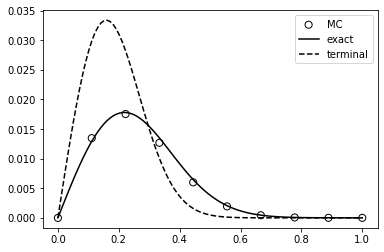

In [7]:
patches = 1
T = patches * 1

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model, exact_example=exact_example)

## Example 1': modified Burgers' equation 3 using the same exact solution
$$
\partial_t u + \frac{\nu}{2} \partial_{xx} u - u^3 \partial_x u = 0,
$$
admits (asymptotically) the traveling wave solution
$$
u(t, x) = \frac{x}{1 + T - t} \left(1 + \alpha \sqrt{1 + T -t}\exp\left(\frac{x^2}{2\nu(1 + T - t)}\right) \right)^{-1}.
$$

In [8]:
problem_name = "mbe3_temp"
nu = .02
alpha = 2

# function definition
deriv_map = np.array([0, 1]).reshape(-1, 1)
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    """
    return - y[0]**3 * y[1]

def phi_example(x, coordinate=0):
    return x[0] / (1 + alpha * torch.exp(x[0]**2 / (2 * nu)))

def exact_example(t, x, T, coordinate=0):
    tt = 1 + T - t
    return x[0] / tt / (1 + alpha * np.sqrt(tt) * np.exp(x[0]**2 / (2 * nu * tt)))

x_lo, x_hi = 0., 1.

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


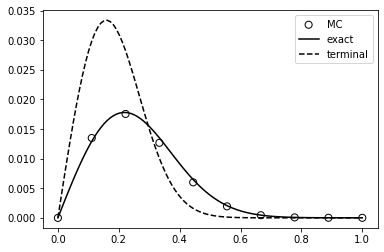

In [9]:
patches = 1
T = patches * 1

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model, exact_example=exact_example)

## Example 2: modified Burgers' equation 3
$$
\partial_t u + \frac{\nu}{2} \partial_{xx} u - u^3 \partial_x u = 0,
$$
with the terminal condition
$$
\phi(x) = A \sin \left( \frac{\pi x}{d} \right),
$$
admits the asymptotic solution
\begin{align*}
u(t, x) &= e^{-k(T-t)} A_1 \sin \left( \frac{\pi x}{d} \right) + e^{-4k(T-t)} B_1 (T-t) \sin \left( \frac{2 \pi x}{d} \right) + e^{-4k(T-t)} B_2 \sin \left( \frac{4 \pi x}{d} \right) \\
& \qquad - e^{-7k(T-t)} \frac{d^2}{3 \nu \pi^2} \sin \left( \frac{\pi x}{d} \right) \left( D_1 (T-t) + E_1 + \frac{d^2 D_1}{3 \nu \pi^2} \right) \\
& \qquad + e^{-7k(T-t)} \frac{d^2}{\nu \pi^2} \sin \left( \frac{3 \pi x}{d} \right) \left( D_2 (T-t) + E_2 - \frac{d^2 D_2}{\nu \pi^2} \right) \\
& \qquad + e^{-7k(T-t)} \frac{d^2}{9 \nu \pi^2} \sin \left( \frac{5 \pi x}{d} \right) \left( D_3 (T-t) + E_3 - \frac{d^2 D_3}{9 \nu \pi^2} \right) \\
& \qquad + e^{-7k(T-t)} \frac{d^2 E_4}{21 \nu \pi^2} \sin \left( \frac{7 \pi x}{d} \right) + \ldots,
\end{align*}
where
$A = 1$,
$d = \pi$,
$k = \frac{\nu \pi^2}{2 d^2}$,
$A_1 = 0.365366$,
$B_1 = -\frac{A_1^4 \pi}{4d}$,
$B_2 = \frac{A_1^4 d}{48 \nu \pi}$,
$D_1 = \frac{A_1^3 B_1 \pi}{4 d}$,
$D_2 = -\frac{9 A_1^3 B_1 \pi}{8 d}$,
$D_3 = -\frac{5 A_1^3 B_1 \pi}{8 d}$,
$E_1 = -\frac{A_1^3 B_2 \pi}{8 d}$,
$E_2 = \frac{9 A_1^3 B_2 \pi}{8 d}$,
$E_3 = -\frac{15 A_1^3 B_2 \pi}{8 d}$,
$E_4 = \frac{7 A_1^3 B_2 \pi}{8 d}$,
see e.g. [the article](https://www.sciencedirect.com/science/article/pii/S0898122110004359).

In [10]:
problem_name = "mbe3"
nu = 1e-2
alpha = 2

A = 1
d = math.pi
k = (nu * math.pi**2)/(2 * d**2)
A1 = 0.365366
B1 = -(A1**4 * math.pi)/(4 * d)
B2 = (A1**4 * d)/(48 * nu * math.pi)
D1 = (A1**3 * B1 * math.pi)/(4 * d)
D2 = -(9 * A1**3 * B1 * math.pi)/(8 * d)
D3 = -(5 * A1**3 * B1 * math.pi)/(8 * d)
E1 = -(A1**3 * B2 * math.pi)/(8 * d)
E2 = (9 * A1**3 * B2 * math.pi)/(8 * d)
E3 = -(15 * A1**3 * B2 * math.pi)/(8 * d)
E4 = (7 * A1**3 * B2 * math.pi)/(8 * d)

# function definition
deriv_map = np.array([0, 1]).reshape(-1, 1)
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    """
    return - y[0]**3 * y[1]

def phi_example(x, coordinate=0):
    return A * torch.sin(math.pi * x[0] / d)

def exact_example(t, x, T, coordinate=0):
    if np.isclose(t, T):
        return A * np.sin(math.pi * x[0] / d)
        
    return (
        np.exp(-k * (T - t)) * A1 * np.sin(math.pi * x[0] / d)
        + np.exp(-4 * k * (T - t)) * B1 * (T - t)
            * np.sin(2 * math.pi * x[0] / d)
        + np.exp(-4 * k * (T - t)) * B2 * np.sin(4 * math.pi * x[0] / d)
        - np.exp(-7 * k * (T - t))
            * (d**2)
            / (3 * nu * math.pi**2)
            * np.sin(math.pi * x[0] / d)
            * (D1 * (T - t) + E1 + (d**2 * D1) / (3 * nu * math.pi**2))
        + np.exp(-7 * k * (T - t))
            * (d**2)
            / (nu * math.pi**2)
            * np.sin(3 * math.pi * x[0] / d)
            * (D2 * (T - t) + E2 - (d**2 * D2) / (nu * math.pi**2))
        + np.exp(-7 * k * (T - t))
            * (d**2)
            / (9 * nu * math.pi**2)
            * np.sin(5 * math.pi * x[0] / d)
            * (D3 * (T - t) + E3 - (d**2 * D3) / (9 * nu * math.pi**2))
        + np.exp(-7 * k * (T - t))
            * (d**2 * E4)
            / (21 * nu * math.pi**2)
            * np.sin(7 * math.pi * x[0] / d)
    )

x_lo, x_hi = 0., math.pi

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


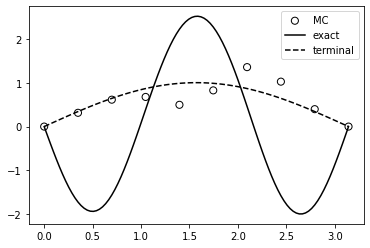

In [11]:
patches = 1
T = patches * 1

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model, exact_example=exact_example)

The MC samples are close to the terminal condition, and seems to be the correct solution.
However, the asymptotic solution (marked as exact) provided by Bratsos does not work for $T = 1$.
Hence, we are unable to benchmark the correctness of MC samples.

## Example 3: time-dependent Poiseuille flow
We consider the 2D Navier-Stokes equation inside the square $[-L, L]^2$. For this, we let the wall be the horizontal lines $y = L$ and $y = L$, and let the inlet at $x = -L$ flowing to the direction $x = L$.

It can be checked that the velocity flow $u(t, x, y) = (g(t, y), 0)$ with the pressure $p(t, x, y) = \alpha v_0^2 - \frac{\nu v_0}{L^2} x$ satisfies the Navier-Stokes equation
$$
\partial_t u(t,x) + \frac{\nu}{2} \Delta u(t,x) =\nabla p(t,x) + ( u \cdot \nabla ) u,
$$
with the divergence free condition ${\rm div \ \! } u = 0$,
where
$$
g(t, y) = v_0 \left( 1 - \frac{y^2}{L^2} \right) + \sum\limits_{n=0}^\infty \frac{(-1)^{n+1} 32 v_0}{\pi^3(2n+1)^3} \cos \frac{(2n+1)\pi y}{2L} \exp\left(- \frac{(2n+1)^2 \pi^2 \nu (T-t)}{8L^2}\right).
$$

In [9]:
# the formula given by Borodin, see compare_boundary_method.ipynb fore more information
def conditional_probability_to_survive(
    t,
    x,
    y,
    k_arr=range(-5, 5),
    lower_bound=-10,
    upper_bound=10,
):
    # in case lower_bound & upper_bound are not tensor
    if not torch.is_tensor(lower_bound):
        lower_bound = torch.tensor(lower_bound, device=device)
    if not torch.is_tensor(upper_bound):
        upper_bound = torch.tensor(upper_bound, device=device)

    # transpose (t, x, y)
    # so that the operation with lower_bound, upper_bound is correct
    t = t.unsqueeze(dim=0).transpose(0, -1)
    x, y = x.transpose(0, -1), y.transpose(0, -1)

    # calculate the probability using the formula by Borodin
    ans = 0
    for k in k_arr:
        ans += (
            torch.exp(
                ((y - x) ** 2 - (y - x + 2*k*(upper_bound-lower_bound)) ** 2) 
                / (2 * t)
            )
            - torch.exp(
                ((y - x) ** 2 - (y + x - 2*lower_bound + 2*k*(upper_bound-lower_bound)) ** 2) 
                / (2 * t)
            )
        )
    return ans.transpose(0, -1).prod(dim=0)

def is_x_inside(x, lower_bound=-10, upper_bound=10):
    # in case lower_bound & upper_bound are not tensor
    if not torch.is_tensor(lower_bound):
        lower_bound = torch.tensor(lower_bound, device=device)
    if not torch.is_tensor(upper_bound):
        upper_bound = torch.tensor(upper_bound, device=device)

    # transpose x so that the operation with lower_bound, upper_bound is correct
    x = x.transpose(0, -1)

    return (
        torch.logical_and(lower_bound <= x, x <= upper_bound)
        .transpose(0, -1).all(dim=0)
    )

In [10]:
problem_name = "navier_stokes_poiseuille"
nu = 5e-9
v0 = 1.25e-5
L = 5e-3
alpha = 2

t_lo, x_lo, x_hi = 0., -L, L

# function definition
deriv_map = np.array(
    [
        [1, 0],  # for nabla p
        [0, 1],
        [0, 0],  # for u
        [0, 0],
        [1, 0],  # for nabla u1
        [0, 1],
        [1, 0],  # for nabla u2
        [0, 1],
    ]
)
zeta_map = np.array([-1, -1, 0, 1, 0, 0, 1, 1])
deriv_condition_deriv_map = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)
deriv_condition_zeta_map = np.array([0, 1])
_, dim = deriv_map.shape

def f_example(y, coordinate):
    """
    idx 0 -> no deriv
    """
    f = -y[coordinate]
    for j in range(dim):
        f += -y[dim + j] * y[2 * dim + dim * coordinate + j]
    return f

def phi_example(x, coordinate, nb_sums=5):
    if coordinate == 0:
        ans = v0 * (1 - x[1]**2 / L**2)
        for n in range(nb_sums):
            ans += (
                32 * (-1)**(n+1) * v0 / (math.pi * (2*n+1))**3
                * torch.cos((2*n+1) * math.pi * x[1] / (2 * L))
            )
        return ans
    else:
        return torch.zeros_like(x[0])

def exact_example_(t, x, T, coordinate, nb_sums=5):
    if coordinate == 0:
        ans = v0 * (1 - x[1]**2 / L**2)
        for n in range(nb_sums):
            ans += (
                32 * (-1)**(n+1) * v0 / (math.pi * (2*n+1))**3
                * np.cos((2*n+1) * math.pi * x[1] / (2 * L))
                * np.exp(
                    -((2*n+1)**2 * math.pi**2 * nu * (T - t))/(8 * L**2)
                )
            )
        return ans
    else:
        return np.zeros_like(x[0])

def p_example_full(x, t):
    return alpha * v0**2 - nu * v0 / L**2 * x[0]

patches = 1
T = patches * 10
MAX_VAL = 100

### nb_sums = 0

Summing 0 term corresponds to starting and staying with the staionary flow $v_0 \left( 1 - \frac{y^2}{L^2} \right)$,
like [the simulation here](deep_branching_with_domain.ipynb#Navier-Stokes-equation-starting-with-the-stationary--Poiseuille-flow).

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


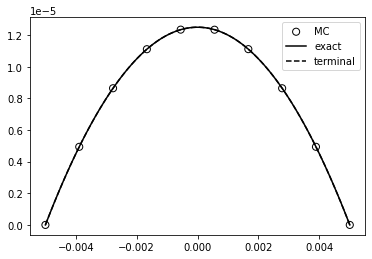

In [11]:
nb_sums = 0
exact_example = partial(exact_example_, nb_sums=nb_sums)

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    exact_p_fun_full=p_example_full,
    phi_fun=partial(phi_example, nb_sums=nb_sums),
    conditional_probability_to_survive=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model, exact_example=exact_example)

### nb_sums = 100

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


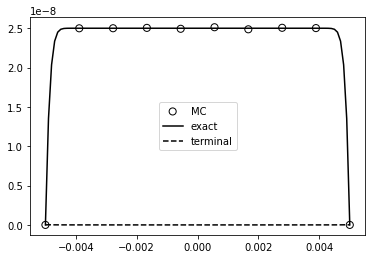

In [12]:
nb_sums = 100
exact_example = partial(exact_example_, nb_sums=nb_sums)

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    exact_p_fun_full=p_example_full,
    phi_fun=partial(phi_example, nb_sums=nb_sums),
    conditional_probability_to_survive=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model, exact_example=exact_example)

# JEEQ paper

## Weinan Allen Cahn (Section 4.2)

In [3]:
problem_name = "allen_cahn_weinan"
nu = 2

fixed_dim, dim = 0, 100

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    """
    return y[0] - y[0] ** 3

def phi_example(x, coordinate=0):
    return 1 / (2 + 2/5 * (x ** 2).sum(dim=0))

x_lo, x_hi = 0., 0.

In [8]:
patches = 1
T = patches * .3

nb_mc = 5  # weinan ran 5 independent runs for Table 1

# define NN and train
start = time.time()
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=100000,
    save_as_tmp=True,
)
x, mc = simulate_mc_and_plot(model, nb_spatial=nb_mc, return_mc=True, repeats=10)
mc = mc.numpy()
tot_time = time.time() - start
time_without_fdb = tot_time - model.fdb_runtime
print(f"fdb time: {model.fdb_runtime:.1f} seconds; total time: {tot_time:.1f} seconds; time without fdb: {time_without_fdb:.1f} seconds.")

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


fdb time: 0.1 seconds; total time: 37.0 seconds; time without fdb: 36.9 seconds.


In [9]:
true_sol = 0.052802  # this is given by Weinan
error = np.abs(mc - true_sol) / true_sol

weinan = [0.0528, 0.0002, 0.0030, 0.0022, 647]
branch = [mc.mean(), mc.std(), error.mean(), error.std(), time_without_fdb // nb_mc]
df = pd.DataFrame({'weinan Table 1': weinan, 'branch': branch}).T
df.columns = ['mean of solution', 'std of solution', 'mean of L1 relative error', 'std of L1 relative error', 'mean of runtime']
df.T

,weinan Table 1,branch
mean of solution,0.0528,0.052754
std of solution,0.0002,0.000364
mean of L1 relative error,0.0030,0.005916
std of L1 relative error,0.0022,0.003661
mean of runtime,647.0000,7.000000


## Weinan HJB (Section 4.3)

In [29]:
problem_name = "hjb_weinan"
nu = 2

fixed_dim, dim = 0, 100

# function definition
deriv_map = np.identity(dim).astype(int)
def f_example(y, coordinate=0):
    """
    idx 0 to d-1 -> first deriv
    """
    return -(y ** 2).sum(dim=0)

def phi_example(x, coordinate=0):
    return torch.log((1 + (x ** 2).sum(dim=0)) / 2)

x_lo, x_hi = 0., 0.

In [30]:
patches = 1
T = patches * 1

nb_mc = 5  # weinan ran 5 independent runs for Table 1
time_list, mc_list = [], []

# define NN and train
start = time.time()
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=100000,
    save_as_tmp=True,
)
x, mc = simulate_mc_and_plot(model, nb_spatial=nb_mc, return_mc=True)
mc = mc.numpy()
tot_time = time.time() - start
time_without_fdb = tot_time - model.fdb_runtime
print(f"fdb time: {model.fdb_runtime:.1f} seconds; total time: {tot_time:.1f} seconds; time without fdb: {time_without_fdb:.1f} seconds.")

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


fdb time: 4124.7 seconds; total time: 4855.3 seconds; time without fdb: 730.6 seconds.


In [31]:
true_sol = 4.5901  # this is given by Weinan
error = np.abs(mc - true_sol) / true_sol

weinan = [4.5977, 0.0019, 0.0017, 0.0004, 330]
branch = [mc.mean(), mc.std(), error.mean(), error.std(), time_without_fdb // nb_mc]
df = pd.DataFrame({'weinan Table 2': weinan, 'branch': branch}).T
df.columns = ['mean of solution', 'std of solution', 'mean of L1 relative error', 'std of L1 relative error', 'mean of runtime']
df.T

,weinan Table 2,branch
mean of solution,4.5977,4.580340
std of solution,0.0019,0.001869
mean of L1 relative error,0.0017,0.002126
std of L1 relative error,0.0004,0.000407
mean of runtime,330.0000,146.000000


## JEEQ Allen Cahn

In [26]:
problem_name = "allen_cahn_jeeq"

fixed_dim, dim = 0, 5

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    """
    return y[0] - y[0] ** 3

def phi_example(x, coordinate=0):
    return -0.5 - 0.5 * torch.nn.Tanh()(-.5 * x.sum(dim=0) / math.sqrt(dim))

def exact_example(t, x, T, coordinate=0):
    return -0.5 - 0.5 * np.tanh(-.5*x.sum(axis=0)/math.sqrt(dim) + 3*(T-t)/4)

x_lo, x_hi = -8, 8

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


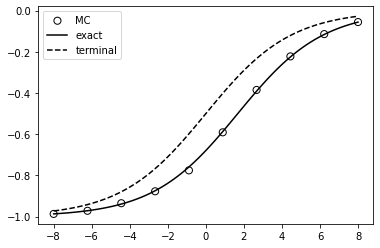

fdb time: 0.0 seconds; total time: 0.6 seconds; time without fdb: 0.6 seconds.


In [27]:
patches = 1
T = patches * .5

start = time.time()

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    branch_patches=patches,
    branch_nb_path_per_state=100000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model, exact_example=exact_example)
tot_time = time.time() - start
time_without_fdb = tot_time - model.fdb_runtime
print(f"fdb time: {model.fdb_runtime:.1f} seconds; total time: {tot_time:.1f} seconds; time without fdb: {time_without_fdb:.1f} seconds.")

### 100-dimensional with T=.3

In [23]:
problem_name = "allen_cahn_jeeq"

fixed_dim, dim = 0, 100

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    """
    return y[0] - y[0] ** 3

def phi_example(x, coordinate=0):
    return -0.5 - 0.5 * torch.nn.Tanh()(-.5 * x.sum(dim=0) / math.sqrt(dim))

def exact_example(t, x, T, coordinate=0):
    return -0.5 - 0.5 * np.tanh(-.5*x.sum(axis=0)/math.sqrt(dim) + 3*(T-t)/4)

x_lo, x_hi = -8, 8

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


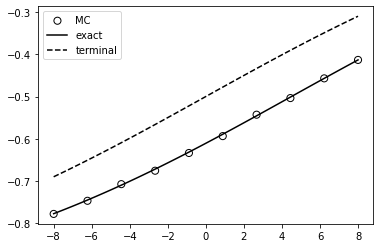

fdb time: 0.0 seconds; total time: 78.7 seconds; time without fdb: 78.6 seconds.


In [25]:
patches = 1
T = patches * .3

start = time.time()

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    branch_patches=patches,
    branch_nb_path_per_state=100000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model, exact_example=exact_example, repeats=10)
tot_time = time.time() - start
time_without_fdb = tot_time - model.fdb_runtime
print(f"fdb time: {model.fdb_runtime:.1f} seconds; total time: {tot_time:.1f} seconds; time without fdb: {time_without_fdb:.1f} seconds.")

## JEEQ exponential nonlinearity

In [28]:
problem_name = "exponential_nonlinearity_jeeq"

fixed_dim, dim = 0, 5
alpha = 10

# function definition
deriv_map = np.concatenate((np.array([[0] * dim]), np.identity(dim)), axis=0).astype(int)
def f_example(y, coordinate=0):
    """
    idx 0      -> no deriv
    idx 1 to d -> first deriv
    """
    return alpha/dim*y[1:].sum(dim=0) - 2*dim*torch.exp(-2*y[0]) + dim*torch.exp(-y[0])

def phi_example(x, coordinate=0):
    return torch.log(1 + x.sum(dim=0) ** 2)

def exact_example(t, x, T, coordinate=0):
    return np.log(1 + (x.sum(axis=0) + alpha * (T - t)) ** 2)

x_lo, x_hi = -4, 4

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


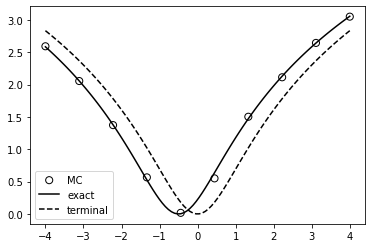

fdb time: 0.3 seconds; total time: 4.9 seconds; time without fdb: 4.6 seconds.


In [29]:
patches = 1
T = patches * .05

start = time.time()

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    branch_patches=patches,
    branch_nb_path_per_state=100000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model, exact_example=exact_example)
tot_time = time.time() - start
time_without_fdb = tot_time - model.fdb_runtime
print(f"fdb time: {model.fdb_runtime:.1f} seconds; total time: {tot_time:.1f} seconds; time without fdb: {time_without_fdb:.1f} seconds.")

### 10-dimensional with T=.05

In [30]:
problem_name = "exponential_nonlinearity_jeeq"

fixed_dim, dim = 0, 10
alpha = 10

# function definition
deriv_map = np.concatenate((np.array([[0] * dim]), np.identity(dim)), axis=0).astype(int)
def f_example(y, coordinate=0):
    """
    idx 0      -> no deriv
    idx 1 to d -> first deriv
    """
    return alpha/dim*y[1:].sum(dim=0) - 2*dim*torch.exp(-2*y[0]) + dim*torch.exp(-y[0])

def phi_example(x, coordinate=0):
    return torch.log(1 + x.sum(dim=0) ** 2)

def exact_example(t, x, T, coordinate=0):
    return np.log(1 + (x.sum(axis=0) + alpha * (T - t)) ** 2)

x_lo, x_hi = -4, 4

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


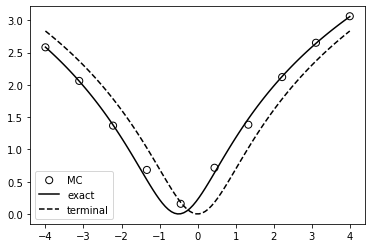

fdb time: 2.5 seconds; total time: 20.1 seconds; time without fdb: 17.6 seconds.


In [33]:
patches = 1
T = patches * .05

start = time.time()

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    branch_patches=patches,
    branch_nb_path_per_state=100000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model, exact_example=exact_example)
tot_time = time.time() - start
time_without_fdb = tot_time - model.fdb_runtime
print(f"fdb time: {model.fdb_runtime:.1f} seconds; total time: {tot_time:.1f} seconds; time without fdb: {time_without_fdb:.1f} seconds.")

## JEEQ Dym

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


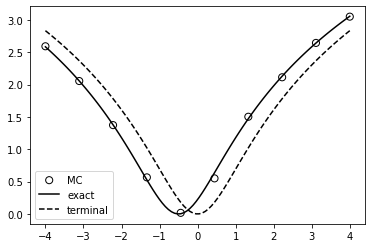

fdb time: 0.2 seconds; total time: 4.5 seconds; time without fdb: 4.3 seconds.


In [13]:
patches = 1
T = patches * .05

start = time.time()

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    branch_patches=patches,
    branch_nb_path_per_state=100000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model, exact_example=exact_example)
tot_time = time.time() - start
time_without_fdb = tot_time - model.fdb_runtime
print(f"fdb time: {model.fdb_runtime:.1f} seconds; total time: {tot_time:.1f} seconds; time without fdb: {time_without_fdb:.1f} seconds.")

In [20]:
problem_name = "dym_jeeq"

fixed_dim, dim = 0, 5
alpha = -2

# function definition
deriv_map = np.concatenate((np.array([[0] * dim]), 2 * np.identity(dim), 3 * np.identity(dim)), axis=0).astype(int)
def f_example(y, coordinate=0):
    """
    idx 0          -> no deriv
    idx 1 to d     -> second deriv
    idx 1+d to 2d  -> third deriv
    """
    return -.5 * y[1:(dim+1)].sum(dim=0) + (y[0] ** 3) * y[(dim+1):].sum(dim=0) / dim

def phi_example(x, coordinate=0):
    ans = (-3 * alpha * x.sum(dim=0))
    return ans.sign() * ans.abs().pow(2/3)

def exact_example(t, x, T, coordinate=0):
    return (-3 * alpha * (x.sum(axis=0) + 4 * alpha**2 * (T - t))) ** (2/3)

x_lo, x_hi = 1, 2

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


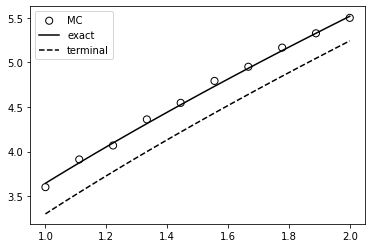

fdb time: 43.6 seconds; total time: 112.9 seconds; time without fdb: 69.2 seconds.


In [21]:
patches = 1
T = patches * .01

start = time.time()

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    branch_patches=patches,
    branch_nb_path_per_state=100000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model, exact_example=exact_example)
tot_time = time.time() - start
time_without_fdb = tot_time - model.fdb_runtime
print(f"fdb time: {model.fdb_runtime:.1f} seconds; total time: {tot_time:.1f} seconds; time without fdb: {time_without_fdb:.1f} seconds.")

## JEEQ quasilinear nonpolynomial

In [22]:
problem_name = "quasilinear_nonpolynomial_jeeq"

fixed_dim, dim = 0, 5
alpha = 10

# function definition
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)
def f_example(y, coordinate=0):
    """
    idx 0          -> no deriv
    idx 1 to d     -> first deriv
    idx 1+d to 2d  -> second deriv
    """
    return -.5 * y[(dim+1):(2*dim+1)].sum(dim=0) + alpha * y[1:(dim+1)].sum(dim=0) / dim + y[(dim+1):].sum(dim=0) / dim / (1 + y[0] ** 2) - 2 * y[0]

def phi_example(x, coordinate=0):
    return torch.tan(x.sum(dim=0))

def exact_example(t, x, T, coordinate=0):
    return np.tan(x.sum(axis=0) + alpha * (T - t))

x_lo, x_hi = -math.pi/4, math.pi/4

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


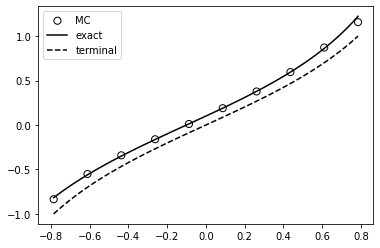

fdb time: 8.1 seconds; total time: 28.1 seconds; time without fdb: 20.0 seconds.


In [23]:
patches = 1
T = patches * .01

start = time.time()

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    branch_patches=patches,
    branch_nb_path_per_state=100000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model, exact_example=exact_example)
tot_time = time.time() - start
time_without_fdb = tot_time - model.fdb_runtime
print(f"fdb time: {model.fdb_runtime:.1f} seconds; total time: {tot_time:.1f} seconds; time without fdb: {time_without_fdb:.1f} seconds.")

## JEEQ cosine nonlinearity

In [24]:
problem_name = "cosine_nonlinearity_jeeq"

fixed_dim, dim = 0, 5
alpha = 10

# function definition
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim), 4 * np.identity(dim)), axis=0).astype(int)
def f_example(y, coordinate=0):
    """
    idx 0          -> no deriv
    idx 1 to d     -> first deriv
    idx 1+d to 2d  -> second deriv
    idx 1+2d to 3d -> forth deriv
    """
    return -.5 * y[(dim+1):(2*dim+1)].sum(dim=0) + alpha * y[1:(dim+1)].sum(dim=0) / dim + y[0] - (y[(dim+1):(2*dim+1)].sum(dim=0) / 12 / dim) ** 2 + torch.cos(math.pi * y[(2*dim+1):] / 24).sum(dim=0) / dim

def phi_example(x, coordinate=0):
    xx = x.sum(dim=0)
    return xx**4 + xx**3 - 36/47 * xx**2 - 24*36/47 * xx + 4 * (36/47)**2

def exact_example(t, x, T, coordinate=0):
    xx = x.sum(axis=0) + alpha * (T - t)
    return xx**4 + xx**3 - 36/47 * xx**2 - 24*36/47 * xx + 4 * (36/47)**2

x_lo, x_hi = -5, 5

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


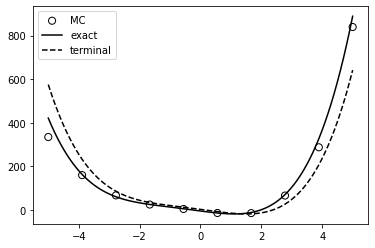

fdb time: 98.4 seconds; total time: 110.6 seconds; time without fdb: 12.1 seconds.


In [25]:
patches = 1
T = patches * .04

start = time.time()

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model, exact_example=exact_example)
tot_time = time.time() - start
time_without_fdb = tot_time - model.fdb_runtime
print(f"fdb time: {model.fdb_runtime:.1f} seconds; total time: {tot_time:.1f} seconds; time without fdb: {time_without_fdb:.1f} seconds.")

## JEEQ log nonlinearity

In [26]:
problem_name = "log_nonlinearity_jeeq"

fixed_dim, dim = 0, 5
alpha = 10

# function definition
deriv_map = np.concatenate((1 * np.identity(dim), 2 * np.identity(dim), 3 * np.identity(dim)), axis=0).astype(int)
def f_example(y, coordinate=0):
    """
    idx 0 to d-1   -> first deriv
    idx d to 2d-1  -> second deriv
    idx 2d to 3d-1 -> third deriv
    """
    return -.5 * y[dim:(2*dim)].sum(dim=0) + alpha * y[:dim].sum(dim=0) / dim + torch.log(((y[dim:(2*dim)]**2).sum(dim=0) + (y[(2*dim):]**2).sum(dim=0)) / dim)

def phi_example(x, coordinate=0):
    return torch.cos(x.sum(dim=0))

def exact_example(t, x, T, coordinate=0):
    return np.cos(x.sum(axis=0) + alpha * (T-t))

x_lo, x_hi = -3, 3

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


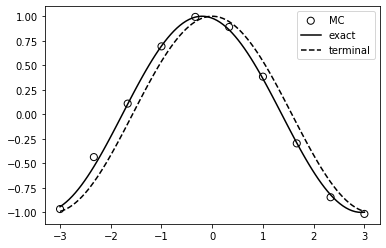

fdb time: 48.5 seconds; total time: 57.1 seconds; time without fdb: 8.6 seconds.


In [28]:
patches = 1
T = patches * .02

start = time.time()

torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    branch_patches=patches,
    branch_nb_path_per_state=10000,
    save_as_tmp=True,
)
simulate_mc_and_plot(model, exact_example=exact_example)
tot_time = time.time() - start
time_without_fdb = tot_time - model.fdb_runtime
print(f"fdb time: {model.fdb_runtime:.1f} seconds; total time: {tot_time:.1f} seconds; time without fdb: {time_without_fdb:.1f} seconds.")

# temporary section..
$$
\partial_t u + \frac{\nu}{2} \partial_{xx} u - u^2 \partial_x u = 0,
$$
admits (asymptotically) the traveling wave solution
$$
u(t, x) = \frac{x}{1 + T - t} \left(1 + \alpha \sqrt{1 + T -t}\exp\left(\frac{x^2}{2\nu(1 + T - t)}\right) \right)^{-1}.
$$
Note that this solution is asymptotic
as $\nu \to 0$,
see e.g. [wolfram alpha](https://www.wolframalpha.com/input?i=D%5Bx%2F%28T-t%29%2F%281%2B2%E2%88%9A%28T-t%29E%5E%28x%5E2%2F%282a%28T-t%29%29%29%29%2Ct%5D%2B%28a%2F2%29D%5BD%5Bx%2F%28T-t%29%2F%281%2B2%E2%88%9A%28T-t%29E%5E%28x%5E2%2F%282a%28T-t%29%29%29%29%2Cx%5D%2Cx%5D-%28x%2F%28T-t%29%2F%281%2B2%E2%88%9A%28T-t%29E%5E%28x%5E2%2F%282a%28T-t%29%29%29%29%29%5E2D%5Bx%2F%28T-t%29%2F%281%2B2%E2%88%9A%28T-t%29E%5E%28x%5E2%2F%282a%28T-t%29%29%29%29%2Cx%5D).
We try to reproduce Fig 1(b) in [this article](https://www.sciencedirect.com/science/article/pii/S0898122110004359).
Note that $t$ in their Fig 1(b) is equal to $T + 1$ here.

In [3]:
problem_name = "mbe2_temp"
nu = .002
alpha = 2

# function definition
deriv_map = np.array([0, 1]).reshape(-1, 1)
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    """
    return - y[0]**2 * y[1]

def phi_example(x, coordinate=0):
    return x[0] / (1 + alpha * torch.exp(x[0]**2 / (2 * nu)))

def exact_example(t, x, T, coordinate=0):
    tt = 1 + T - t
    return x[0] / tt / (1 + alpha * np.sqrt(tt) * np.exp(x[0]**2 / (2 * nu * tt)))

x_lo, x_hi = 0., .5

Logs are saved in /home/nguwijy/deep_branching_with_domain/notebooks/logs/tmp


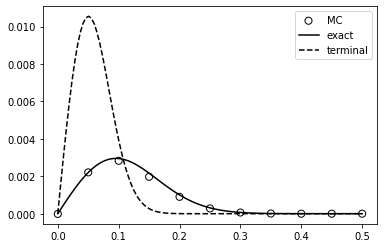

In [4]:
patches = 1
T = patches * 3

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000000,
    save_as_tmp=True,
)
x, mc = simulate_mc_and_plot(model, nb_spatial=11, return_mc=True, exact_example=exact_example)

In [5]:
exact = [0.00000000, 0.00220207, 0.00295055, 0.00216481, 0.00100543, 0.00031274, 0.00006756, 0.00001035, 0.00000113, 0.00000009, 0.00000001]
ramadan = [0.00000000, 0.00215952, 0.00277854, 0.00195596, 0.00089624, 0.00028164, 0.00006207, 0.00000970, 0.00000108, 0.00000009, 0.00000001]
df = np.stack([x, mc, exact, ramadan], axis=-1)
df = pd.DataFrame(df, columns=['x', 'branch', 'exact', 'ramadan'])
df

,x,branch,exact,ramadan
0,0.00,-1.168849e-05,0.000000e+00,0.000000e+00
1,0.05,2.209565e-03,2.202070e-03,2.159520e-03
2,0.10,2.829388e-03,2.950550e-03,2.778540e-03
3,0.15,1.973155e-03,2.164810e-03,1.955960e-03
4,0.20,9.024348e-04,1.005430e-03,8.962400e-04
5,0.25,2.824893e-04,3.127400e-04,2.816400e-04
6,0.30,6.251056e-05,6.756000e-05,6.207000e-05
7,0.35,9.555928e-06,1.035000e-05,9.700000e-06
8,0.40,2.852649e-07,1.130000e-06,1.080000e-06
9,0.45,9.378285e-10,9.000000e-08,9.000000e-08
